

# Trading Signals using Logistic Regression
~By Harshavarda Kumarasamy(23NA10017)

Importing Necessary Libraries

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

Multiclass Logistic Regression Function

In [ ]:
#Explanation for this regression has been given in my report

class MulticlassLogisticRegression:
  def __init__(self, learning_rate, iterations, lmbda, cv):
    self.learning_rate = learning_rate
    self.iterations = iterations
    self.lmbda = lmbda
    self.cv = cv
    self.classifiers = []

  def softmax(self, z):
    return np.exp(z) / np.sum(np.exp(z), axis=0)

  def fit(self, X, y):
    self.classifiers = []
    classes = np.unique(y)

    for class_label in classes:
      y_binary = np.where(y == class_label, 1, 0)
      classifier = LogisticRegression(self.learning_rate, self.iterations, self.lmbda, self.cv)
      classifier.fit(X, y_binary)
      self.classifiers.append(classifier)

  def predict(self, X):
    predictions = []
    for classifier in self.classifiers:
      predictions.append(classifier.predict(X))
    predictions = np.vstack(predictions).T
    return np.argmax(self.softmax(predictions), axis=1)


class LogisticRegression:
  def __init__(self, learning_rate, iterations, lmbda, cv):
    self.learning_rate = learning_rate
    self.iterations = iterations
    self.lmbda = lmbda
    self.cv = cv

  def sigmoid(self, z):
    return 1 / (1 + np.exp(-z))

  def kfold_split(self, X, y):
    splits = []
    fold_size = len(X) // self.cv
    start = 0
    for i in range(self.cv):
      end = start + fold_size
      splits.append((X[start:end], y[start:end]))
      start = end
    return splits

  def fit(self, X, y):
    self.w = np.zeros(X.shape[1])
    m = len(y)
    splits = self.kfold_split(X, y)

    for i in range(self.iterations):
      for X_train, y_train in splits:
        z = np.dot(X_train, self.w)
        h = self.sigmoid(z)
        gradient = (1 / m) * np.dot(X_train.T, (h - y_train)) + (self.lmbda / m) * self.w
        self.w -= self.learning_rate * gradient

  def predict(self, X):
    z = np.dot(X, self.w)
    return np.round(self.sigmoid(z))

Function for standard scaling

In [ ]:
def scaling(X):
  #For standard scaling
  mean = np.mean(X, axis=0)
  std = np.std(X, axis=0)
  std[std == 0] = 1 #In order to avoid division by 0
  X_scaled = (X - mean) / std
  return X_scaled

Calculating Accuracy, F1 score and AUC-ROC score.

In [ ]:

def calculate_accuracy(y, y_pred):
  y_pred_encoded = tf.keras.utils.to_categorical(y_pred, num_classes=3)
  y_encoded = tf.keras.utils.to_categorical(y, num_classes=3)
  accuracy = accuracy_score(y_encoded, y_pred_encoded)
  return accuracy

def calculate_f1_score(y, y_pred):
  y_pred_encoded = tf.keras.utils.to_categorical(y_pred, num_classes=3)
  y_encoded = tf.keras.utils.to_categorical(y, num_classes=3)
  f1 = f1_score(np.argmax(y_encoded, axis=1),np.argmax(y_pred_encoded, axis=1), average='weighted')
  return f1

def calculate_roc_score(y, y_pred):
  y_pred_encoded = tf.keras.utils.to_categorical(y_pred, num_classes=3)
  y_encoded = tf.keras.utils.to_categorical(y, num_classes=3)
  roc_auc = roc_auc_score(np.argmax(y_encoded, axis=1), y_pred_encoded, multi_class='ovr')
  return roc_auc

Defining Technical indicators as function. Simple Moving Average(SMA), Exponential Moving Average(EMA), Moving Average Convergence Divergence(MACD), On Balance Volume(OBV), Average True Range(ATR), Avergae Directional Index(ADX), Stochastic Oscillator and Relative Strength Index(RSI) have been used.

In [ ]:
def calculate_SMA(price_data, window):
  sma = price_data['Close'].rolling(window=window).mean()
  return sma

def calculate_EMA(price_data, window):
  ema = price_data['Close'].ewm(span=window, min_periods=window).mean()
  return ema

def calculate_MACD(price_data, short_window, long_window, signal_window):
  short_ema = calculate_EMA(price_data, short_window)
  long_ema = calculate_EMA(price_data, long_window)
  macd_line = short_ema - long_ema
  signal_line = macd_line.ewm(span=signal_window, min_periods=signal_window).mean()
  return macd_line, signal_line

def calculate_OBV(price_data):
  obv = np.where(price_data['Close'] > price_data['Close'].shift(1), price_data['Volume'], np.where(price_data['Close'] < price_data['Close'].shift(1), -price_data['Volume'], 0)).cumsum()
  return obv

def calculate_BB(price_data, window):
  sma = calculate_SMA(price_data, window)
  std = price_data['Close'].rolling(window=window).std()
  upper_band = sma + 2 * std
  lower_band = sma - 2 * std
  return upper_band, lower_band

def calculate_ADX(price_data, window):
  tr1 = np.abs(price_data['High'] - price_data['Low'])
  tr2 = np.abs(price_data['High'] - price_data['Close'].shift(1))
  tr3 = np.abs(price_data['Low'] - price_data['Close'].shift(1))
  true_range = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)

  plus_dm = np.where((price_data['High'] - price_data['High'].shift(1)) > (price_data['Low'].shift(1) - price_data['Low']),
                    price_data['High'] - price_data['High'].shift(1), 0)
  minus_dm = np.where((price_data['Low'].shift(1) - price_data['Low']) > (price_data['High'] - price_data['High'].shift(1)),
                     price_data['Low'].shift(1) - price_data['Low'], 0)

  plus_di = 100 * np.cumsum(plus_dm) / np.cumsum(true_range)
  minus_di = 100 * np.cumsum(minus_dm) / np.cumsum(true_range)
  dx = 100 * np.abs(plus_di - minus_di) / (plus_di + minus_di)

  adx = np.zeros(len(price_data))
  adx[window-1] = np.mean(dx[:window])
  for i in range(window, len(price_data)):
    adx[i] = (adx[i-1] * (window - 1) + dx[i]) / window

  return pd.Series(adx, index=price_data.index)

def calculate_stochastic_oscillator(price_data, window):
  low_min = price_data['Low'].rolling(window=window).min()
  high_max = price_data['High'].rolling(window=window).max()
  stoch_k = 100 * ((price_data['Close'] - low_min) / (high_max - low_min))
  stoch_d = stoch_k.rolling(window=3).mean()
  return stoch_k, stoch_d

def calculate_ATR(price_data, window):
  tr1 = np.abs(price_data['High'] - price_data['Low'])
  tr2 = np.abs(price_data['High'] - price_data['Close'].shift(1))
  tr3 = np.abs(price_data['Low'] - price_data['Close'].shift(1))
  true_range = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
  atr = true_range.rolling(window=window).mean()
  return atr


def calculate_RSI(price_data, window):
    delta = price_data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    RS = gain / loss
    RSI = 100 - (100 / (1 + RS))
    return RSI

Feature Engineering Function to add new columns pertaining the various features used in the original price data set.

In [ ]:
def feature_engineering(price_data):
    price_data['sma'] = calculate_SMA(price_data, window=20)
    price_data['ema'] = calculate_EMA(price_data, window=20)
    price_data['macd_line'], price_data['signal_line'] = calculate_MACD(price_data, short_window=12, long_window=26, signal_window=9)
    price_data['obv'] = calculate_OBV(price_data)
    price_data['upper_band'], price_data['lower_band'] = calculate_BB(price_data, window=20)
    price_data['adx'] = calculate_ADX(price_data, window=14)
    price_data['stoch_k'], price_data['stoch_d'] = calculate_stochastic_oscillator(price_data, window=14)
    price_data['atr'] = calculate_ATR(price_data, window=14)
    price_data['RSI']=calculate_RSI(price_data, window=14)

    price_data['Bollinger_Band_Width'] = price_data['upper_band']-price_data['lower_band']
    price_data['sma_rsi_ratio'] = price_data['sma'] / price_data['RSI']

    return price_data

Function for plotting closing price along with Buy and Sell positions with some technical indicators

In [ ]:
def plotting(price_data):
  fig, ax1 = plt.subplots(figsize=(12, 6))
  #Plotting SMA
  ax1.plot(price_data['Close'], label='Close', color='green')
  ax1.plot(price_data['sma'], label='SMA', color='blue')
  ax1.set_xlabel('Date')
  ax1.set_ylabel('Close Price(INR)')
  ax1.set_title('Simple Moving Average')
  ax1.legend()

  for i, row in price_data.iterrows(): #Adding Buy and Sell positions as scatterplot on closing price line.
      if row['Position'] == 'Buy':
          ax1.scatter(i, row['Close'], marker='^', color='red', label='Buy')  # Upward triangle for buy
      elif row['Position'] == 'Sell':
          ax1.scatter(i, row['Close'], marker='v', color='blue', label='Sell') #Downward triangle for sell
  #Plotting ATR
  fig, ax2 = plt.subplots(figsize=(12, 6))

  ax2.plot(price_data['Close'], label='Close', color='green')
  ax2.plot(price_data['atr'], label='ATR', color='blue')
  ax2.set_xlabel('Date')
  ax2.set_ylabel('Close Price(INR)')
  ax2.set_title('Average True Range')
  ax2.legend()

  for i, row in price_data.iterrows():
      if row['Position'] == 'Buy':
          ax2.scatter(i, row['Close'], marker='^', color='red', label='Buy')
      elif row['Position'] == 'Sell':
          ax2.scatter(i, row['Close'], marker='v', color='blue', label='Sell')
  #Plotting Bollinger Bands
  fig, ax3 = plt.subplots(figsize=(12, 6))

  ax3.plot(price_data['Close'], label='Close', color='green')
  ax3.plot(price_data['upper_band'], label='Upper Band', color='blue')
  ax3.plot(price_data['lower_band'], label='Lower Band', color='red')
  ax3.set_xlabel('Date')
  ax3.set_ylabel('Close Price(INR)')
  ax3.set_title('Bollinger Bands')
  ax3.legend()

  for i, row in price_data.iterrows():
      if row['Position'] == 'Buy':
          ax3.scatter(i, row['Close'], marker='^', color='red', label='Buy')
      elif row['Position'] == 'Sell':
          ax3.scatter(i, row['Close'], marker='v', color='blue', label='Sell')
  #Plotting MACD
  fig, ax4 = plt.subplots(figsize=(12, 6))
  ax4.plot(price_data['Close'], label='Close', color='green')
  ax4.plot(price_data['macd_line'], label='MACD Line', color='blue')
  ax4.plot(price_data['signal_line'], label='Signal Line', color='red')
  ax4.set_xlabel('Date')
  ax4.set_ylabel('Close Price(INR)')
  ax4.set_title('Moving Average Convergence Divergence')
  ax4.legend()

  for i, row in price_data.iterrows():
      if row['Position'] == 'Buy':
          ax4.scatter(i, row['Close'], marker='^', color='red', label='Buy')
      elif row['Position'] == 'Sell':
          ax4.scatter(i, row['Close'], marker='v', color='blue', label='Sell')
  #Plotting RSI
  fig, ax5 = plt.subplots(figsize=(12, 6))
  ax5.plot(price_data['Close'], label='Close', color='green')
  ax5.plot(price_data['RSI'], label='RSI', color='blue')
  ax5.set_xlabel('Date')
  ax5.set_ylabel('Close Price(INR)')
  ax5.set_title('Relative Strength Index')
  ax5.legend()

  for i, row in price_data.iterrows():
      if row['Position'] == 'Buy':
          ax5.scatter(i, row['Close'], marker='^', color='red', label='Buy')
      elif row['Position'] == 'Sell':
          ax5.scatter(i, row['Close'], marker='v', color='blue', label='Sell')
  #Plotting Bollinger Band Width
  fig, ax6 = plt.subplots(figsize=(12, 6))
  ax6.plot(price_data['Close'], label='Close', color='green')
  ax6.plot(price_data['Bollinger_Band_Width'], label='Bollinger Band Width', color='blue')
  ax6.set_xlabel('Date')
  ax6.set_ylabel('Close Price(INR)')
  ax6.set_title('Bollinger Band Width')
  ax6.legend()

  for i, row in price_data.iterrows():
      if row['Position'] == 'Buy':
          ax6.scatter(i, row['Close'], marker='^', color='red', label='Buy')
      elif row['Position'] == 'Sell':
          ax6.scatter(i, row['Close'], marker='v', color='blue', label='Sell')
  #Plotting SMA/RSI ratio
  fig, ax7 = plt.subplots(figsize=(12, 6))
  ax7.plot(price_data['Close'], label='Close', color='green')
  ax7.plot(price_data['sma_rsi_ratio'], label='SMA/RSI Ratio', color='blue')
  ax7.set_xlabel('Date')
  ax7.set_ylabel('Close Price(INR)')
  ax7.set_title('SMA/RSI ratio')
  ax7.legend()

  for i, row in price_data.iterrows():
      if row['Position'] == 'Buy':
          ax7.scatter(i, row['Close'], marker='^', color='red', label='Buy')
      elif row['Position'] == 'Sell':
          ax7.scatter(i, row['Close'], marker='v', color='blue', label='Sell')

Importing data and feature engineering

In [ ]:
price_data = yf.download("TCS.NS", start="2013-01-01", end="2018-01-01")
print(price_data)
price_data=feature_engineering(price_data)

[*********************100%%**********************]  1 of 1 completed

                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2013-01-01   633.474976   633.950012   630.000000   632.075012   504.629089   
2013-01-02   633.500000   636.200012   627.775024   631.650024   504.289886   
2013-01-03   632.500000   642.000000   629.974976   640.299988   511.195679   
2013-01-04   642.500000   650.500000   640.450012   649.599976   518.620483   
2013-01-07   650.000000   652.000000   645.125000   647.424988   516.884094   
...                 ...          ...          ...          ...          ...   
2017-12-22  1302.000000  1331.949951  1295.099976  1323.375000  1164.538818   
2017-12-26  1343.000000  1344.875000  1315.800049  1324.724976  1165.726807   
2017-12-27  1324.724976  1329.250000  1305.250000  1309.949951  1152.725098   
2017-12-28  1304.400024  1326.750000  1302.824951  1313.474976  1155.827026   
2017-12-29  1311.550049  1354.449951  1309.275024  1

Labeling Data

In [ ]:
price_data['Price_Direction'] = (price_data['Close'].shift(-1) > price_data['Close']).astype(int)

labels=price_data['Price_Direction']
position = []
target=[]
money=12000
shares=0

for i in range(len(labels)):
  close_price = price_data.iloc[i]['Close']

  if labels[i]== 0 and shares > 0:  # Sell condition
        money += shares * close_price  # Add money from selling shares
        shares = 0  # Reset shares to 0 after selling
        position.append('Sell')
        target.append(0)
  elif labels[i-1] == 1 and shares == 0:  # Buy condition
        shares = money // close_price  # Buy as many shares as possible
        money -= shares * close_price  # Reduce money by the purchase cost
        position.append('Buy')
        target.append(2)
  else:
        position.append('Hold')
        target.append(1)

#Adding the target variable and corresponding ideal positions
price_data['Ideal_Position'] = position
price_data['target']= target
print(price_data[:20])

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2013-01-01  633.474976  633.950012  630.000000  632.075012  504.629089   
2013-01-02  633.500000  636.200012  627.775024  631.650024  504.289886   
2013-01-03  632.500000  642.000000  629.974976  640.299988  511.195679   
2013-01-04  642.500000  650.500000  640.450012  649.599976  518.620483   
2013-01-07  650.000000  652.000000  645.125000  647.424988  516.884094   
2013-01-08  647.500000  652.150024  647.150024  650.125000  519.039673   
2013-01-09  650.500000  653.700012  636.575012  638.299988  509.599121   
2013-01-10  639.950012  641.049988  627.650024  629.200012  502.333984   
2013-01-11  645.000000  661.250000  645.000000  653.174988  521.474731   
2013-01-14  659.500000  674.224976  653.674988  667.250000  532.711670   
2013-01-15  695.000000  700.000000  663.500000  668.724976  533.889160   
2013-01-16  668.450012  677.500000  65

Defining features and target values. Model training.

In [ ]:
features = [ 'sma','obv','ema','macd_line','signal_line','upper_band','lower_band','adx','stoch_k',
            'stoch_d','atr','RSI', 'sma_rsi_ratio', 'Bollinger_Band_Width'
            ]
price_data=price_data.dropna()
X = price_data[features]
y = price_data['target']
X_scaled = scaling(X)
print(X.shape,y.shape)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42)
model = MulticlassLogisticRegression(learning_rate=0.1, iterations=2500, lmbda=0.1, cv=9)
model.fit(X_train, y_train)
y_pred=model.predict(X_test)

(1199, 14) (1199,)


Evaluating the model with the test set

In [ ]:
# Step 6: Model Evaluation
y_pred= model.predict(X_test)
accuracy = calculate_accuracy(y_test, y_pred)
print("Accuracy:", accuracy)

f1 = calculate_f1_score(y_test, y_pred)
print("F1 Score:", f1)

roc_auc=calculate_roc_score(y_test,y_pred)
print("AUC-ROC score", roc_auc)

Accuracy: 0.51
F1 Score: 0.5017505501368354
AUC-ROC score 0.6033518540989928


Applying trained model to whole dataset to calculate overall change in initial capital


In [ ]:
predicted_labels = model.predict(X_scaled)

# Initialising an empty list to store positions
positions = []
money=12000
shares=0

for i in range(len(predicted_labels)):
  close_price = price_data.iloc[i]['Close']

  if predicted_labels[i]== 0 and shares > 0:  # Sell condition
        money += shares * close_price  # Add money from selling shares
        shares = 0  # Reset shares to 0 after selling
        positions.append('Sell')
  elif predicted_labels[i-1] == 2 and shares == 0:  # Buy condition
        shares = money // close_price  # Buy as many shares as possible
        money -= shares * close_price  # Reduce money by the purchase cost
        positions.append('Buy')
  else:
        positions.append('Hold')

# Adding positions to the price_data DataFrame
price_data['Position'] = positions

# If there are remaining shares, sell them at the last closing price
if shares > 0:
    money += shares * close_price

<ipython-input-244-e280b1c25b6d>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_data['Position'] = positions


Model Evaluation of entire dataset(it will be slightly biased but it serves a basis for backtesting)

In [ ]:
#Model Evaluation
print('Model Evaluation:')
print('Initial Sum of money=12000')
print(f'Final sum of money={money}')
print(f'Percent profit/loss={((money-12000)/12000)*100}')
accuracy = calculate_accuracy(y, predicted_labels)
print("Accuracy:", accuracy)

f1 = calculate_f1_score(y, predicted_labels)
print("F1 Score:", f1)


roc_auc = calculate_roc_score(y, predicted_labels)
print("AUC-ROC score", roc_auc)

print('Final Dataset:')
print(price_data.head(20))



Model Evaluation:
Initial Sum of money=12000
Final sum of money=20561.23095703125
Percent profit/loss=71.34359130859374
Accuracy: 0.5170975813177648
F1 Score: 0.5172109356772483
AUC-ROC score 0.5973864582388977
Final Dataset:
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2013-02-15  722.000000  725.900024  715.325012  721.075012  576.997742   
2013-02-18  720.049988  720.950012  710.000000  712.674988  570.276184   
2013-02-19  710.799988  724.450012  706.349976  721.775024  577.558167   
2013-02-20  720.750000  728.500000  720.750000  726.400024  581.258850   
2013-02-21  720.349976  728.424988  720.349976  725.525024  580.558777   
2013-02-22  725.000000  732.025024  721.150024  727.549988  582.178833   
2013-02-25  726.500000  737.500000  725.750000  736.849976  589.620728   
2013-02-26  733.500000  749.974976  733.000000  748.200012  598.702881   
2013-02-27  747.625000  751.525024

Plotting graphs with technical indicators

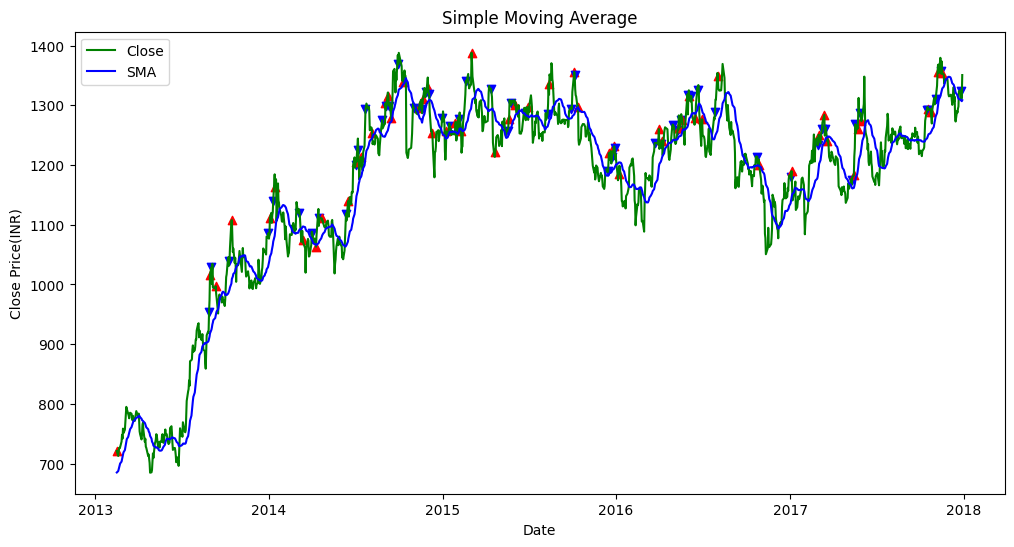

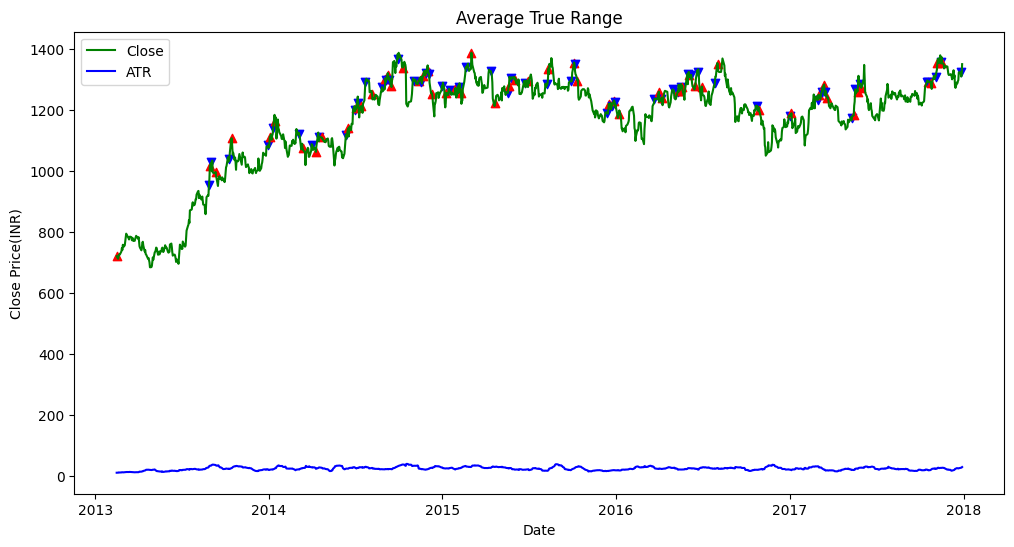

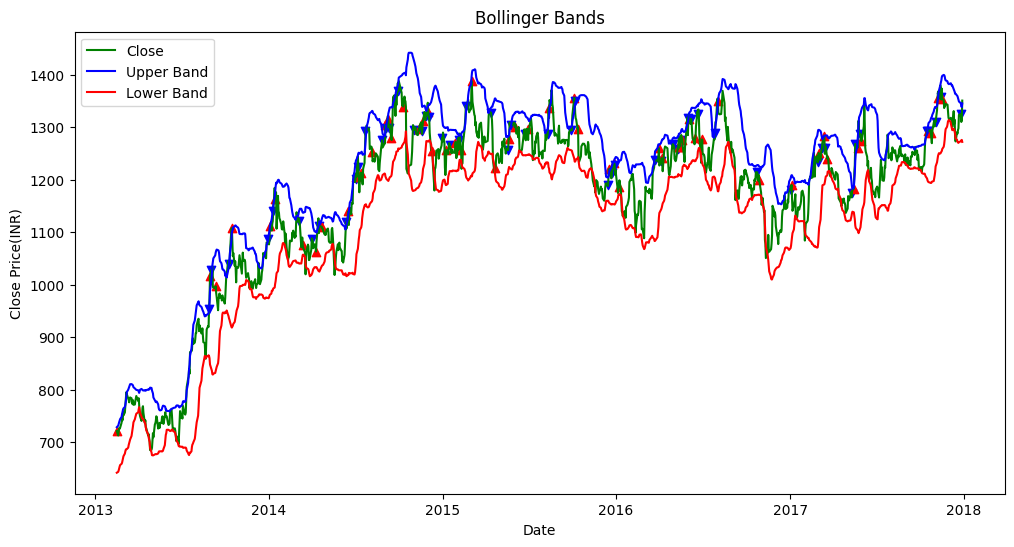

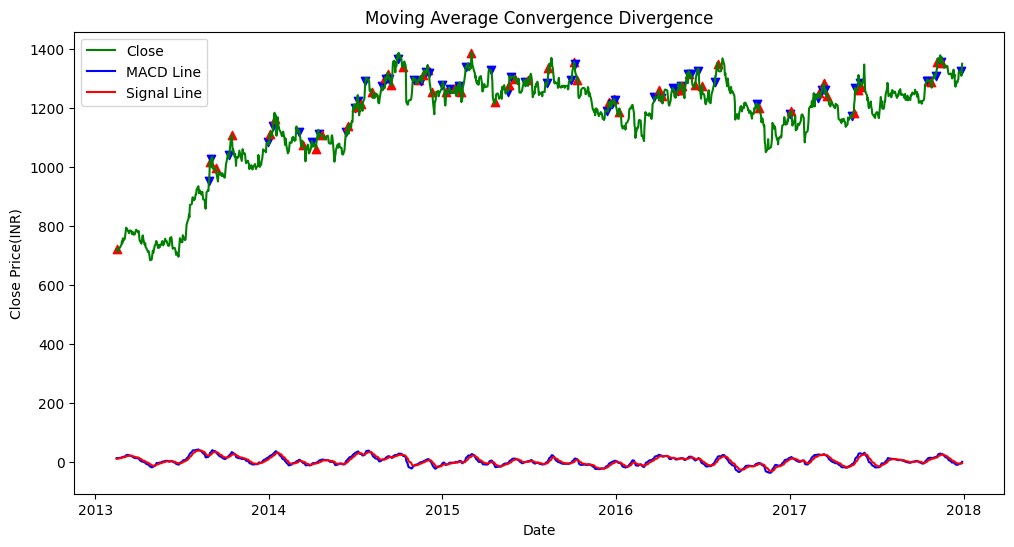

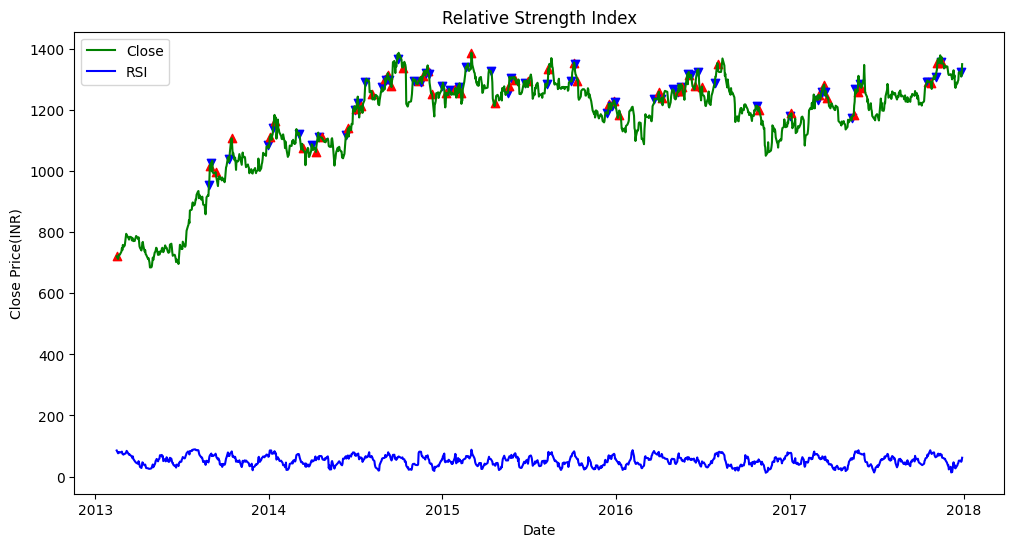

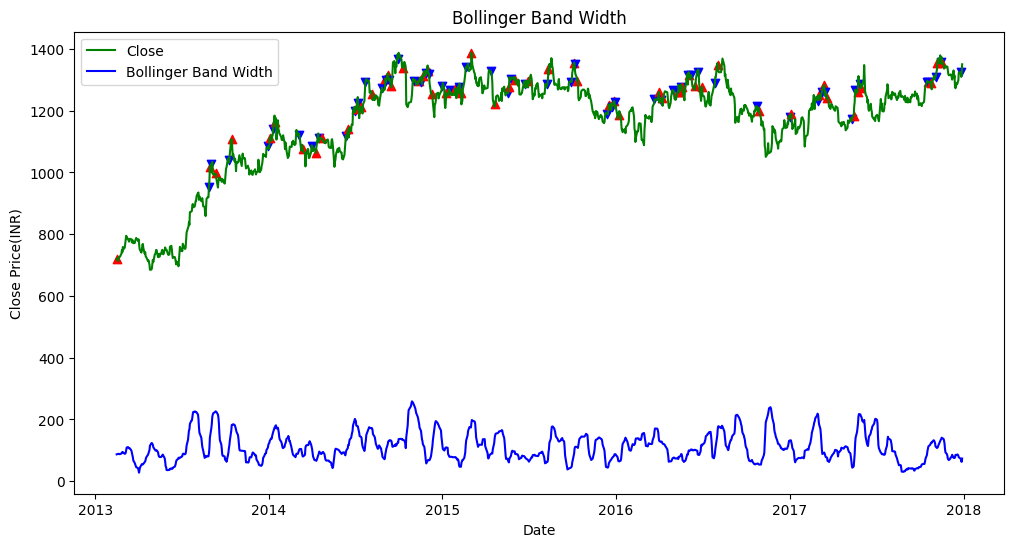

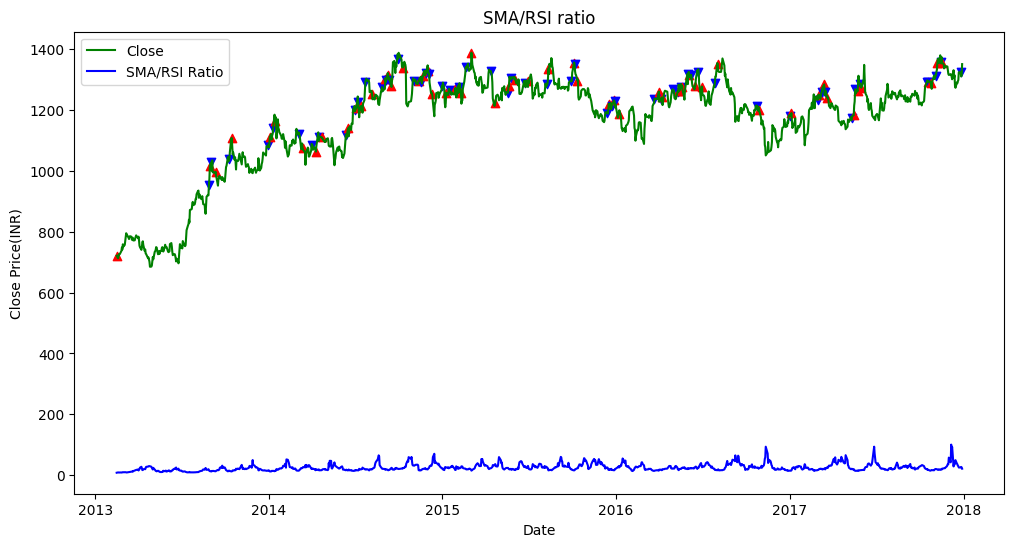

In [ ]:
plotting(price_data)

# Back Testing 1:(2006 to 2007 data)



Importing data and feature engineering

In [ ]:
#Importing data and feature engineering
price_data = yf.download("TCS.NS", start="2006-01-01", end="2007-01-01")
price_data=feature_engineering(price_data)

[*********************100%%**********************]  1 of 1 completed


Labeling Data

In [ ]:
#Labeling Data
price_data['Price_Direction'] = (price_data['Close'].shift(-1) > price_data['Close']).astype(int)
labels = price_data['Price_Direction']

position = []
target=[]
money=12000
shares=0

for i in range(len(labels)):
  close_price = price_data.iloc[i]['Close']

  if labels[i]== 0 and shares > 0:  # Sell condition
        money += shares * close_price  # Add money from selling shares
        shares = 0  # Reset shares to 0 after selling
        position.append('Sell')
        target.append(0)
  elif labels[i-1] == 1 and shares == 0:  # Buy condition
        shares = money // close_price  # Buy as many shares as possible
        money -= shares * close_price  # Reduce money by the purchase cost
        position.append('Buy')
        target.append(2)
  else:
        position.append('Hold')
        target.append(1)

price_data['Ideal_positions'] = position
price_data['target'] = target
print(price_data)

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2006-01-02  213.500000  213.862503  210.169998  210.949997  151.458206   
2006-01-03  210.657501  217.494995  210.250000  216.649994  155.550659   
2006-01-04  217.500000  218.737503  215.274994  217.887497  156.439194   
2006-01-05  218.125000  218.250000  215.237503  216.544998  155.475311   
2006-01-06  216.875000  217.487503  211.500000  213.199997  153.073669   
...                ...         ...         ...         ...         ...   
2006-12-22  283.750000  290.000000  282.024994  288.487488  209.020828   
2006-12-26  288.250000  298.600006  288.250000  297.850006  215.804337   
2006-12-27  298.750000  301.500000  295.262512  299.000000  216.637527   
2006-12-28  301.350006  305.000000  297.000000  302.975006  219.517487   
2006-12-29  303.362488  307.350006  300.625000  305.500000  221.346970   

             Volume         sma      

Defining features and target variable.

In [ ]:
#Defining features and target
features = [ 'sma','obv','ema','macd_line','signal_line','upper_band','lower_band','adx','stoch_k',
            'stoch_d','atr','RSI', 'sma_rsi_ratio', 'Bollinger_Band_Width'
            ]
price_data=price_data.dropna()
X = price_data[features]
y = price_data['target']
X_scaled = scaling(X)
print(X.shape,y.shape)


(214, 14) (214,)


Calculating changes in the intial capital

In [ ]:
# Calculating changes in the intial capital
predicted_labels = model.predict(X_scaled)

# Initialising an empty list to store positions
positions = []
money=12000
shares=0

for i in range(len(predicted_labels)):
  close_price = price_data.iloc[i]['Close']

  if predicted_labels[i]== 0 and shares > 0:  # Sell condition
        money += shares * close_price  # Add money from selling shares
        shares = 0  # Reset shares to 0 after selling
        positions.append('Sell')
  elif predicted_labels[i-1] == 2 and shares == 0:  # Buy condition
        shares = money // close_price  # Buy as many shares as possible
        money -= shares * close_price  # Reduce money by the purchase cost
        positions.append('Buy')
  else:
        positions.append('Hold')

# Adding positions to the price_data DataFrame
price_data['Position'] = positions

# If there are remaining shares, sell them at the last closing price
if shares > 0:
    money += shares * close_price

<ipython-input-250-f0175583a025>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_data['Position'] = positions


Model Evaluation

In [ ]:
#Model Evaluation
print('Model Evaluation:')
print('Initial Sum of money=12000')
print(f'Final sum of money={money}')
print(f'Percent profit/loss={((money-12000)/12000)*100}')
accuracy = calculate_accuracy(y, predicted_labels)
print("Accuracy:", accuracy)

f1 = calculate_f1_score(y, predicted_labels)
print("F1 Score:", f1)
print('Final Dataset:')

roc_auc=calculate_roc_score(y, predicted_labels)
print("AUC-ROC score", roc_auc)

print(price_data.head(20))


Model Evaluation:
Initial Sum of money=12000
Final sum of money=17763.676483154297
Percent profit/loss=48.030637359619135
Accuracy: 0.4719626168224299
F1 Score: 0.4854323123767128
Final Dataset:
AUC-ROC score 0.5602135659105203
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2006-02-21  206.875000  208.875000  206.387497  208.250000  149.796463   
2006-02-22  208.750000  208.750000  206.412506  207.732498  149.424225   
2006-02-23  207.500000  211.237503  207.500000  208.820007  150.206482   
2006-02-24  208.782501  210.000000  207.037506  208.757507  150.161591   
2006-02-27  208.375000  211.875000  208.300003  211.294998  151.986755   
2006-02-28  211.875000  213.000000  208.750000  212.600006  152.925507   
2006-03-01  212.500000  218.175003  210.907501  217.524994  156.468094   
2006-03-02  218.175003  219.250000  215.044998  217.725006  156.611969   
2006-03-03  217.750000  217.7500

Plotting Graphs with technical indicators

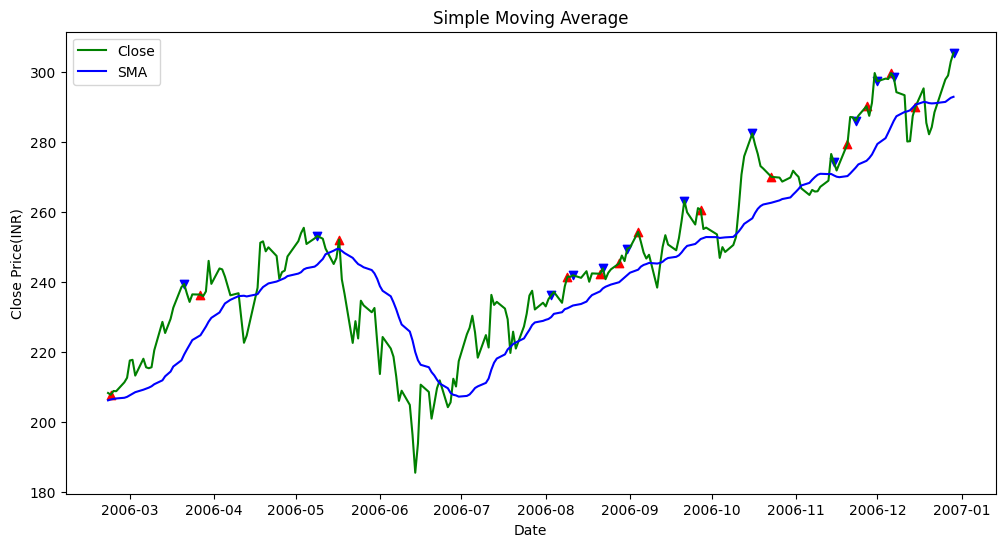

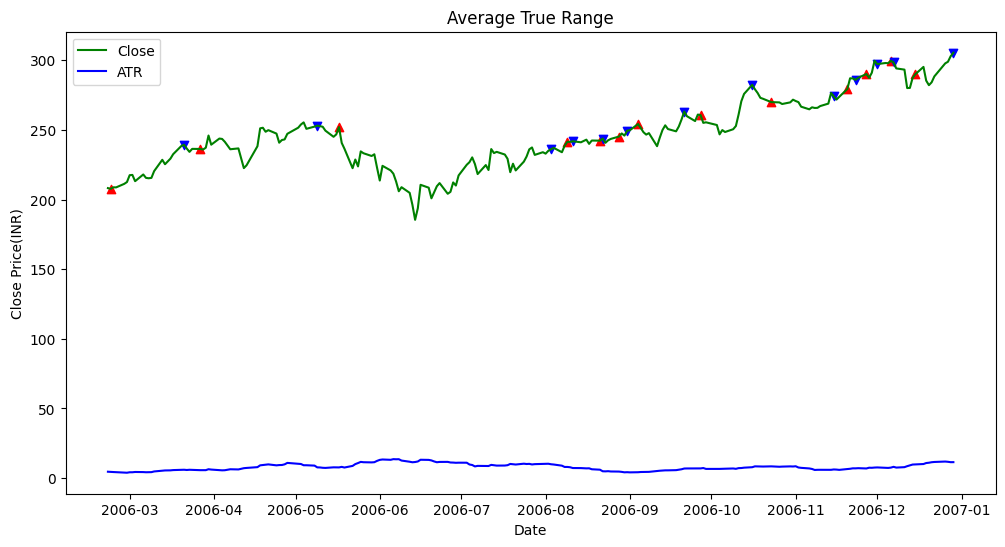

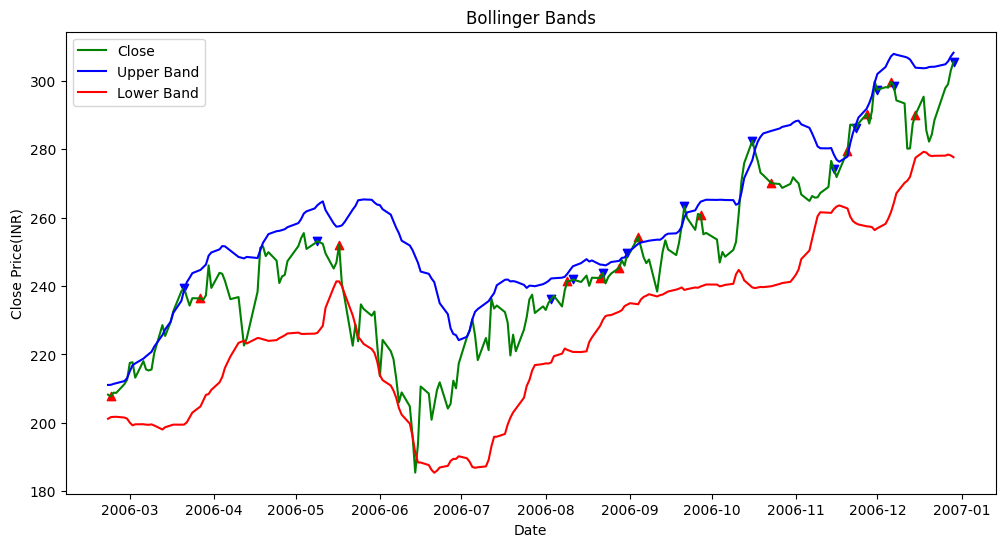

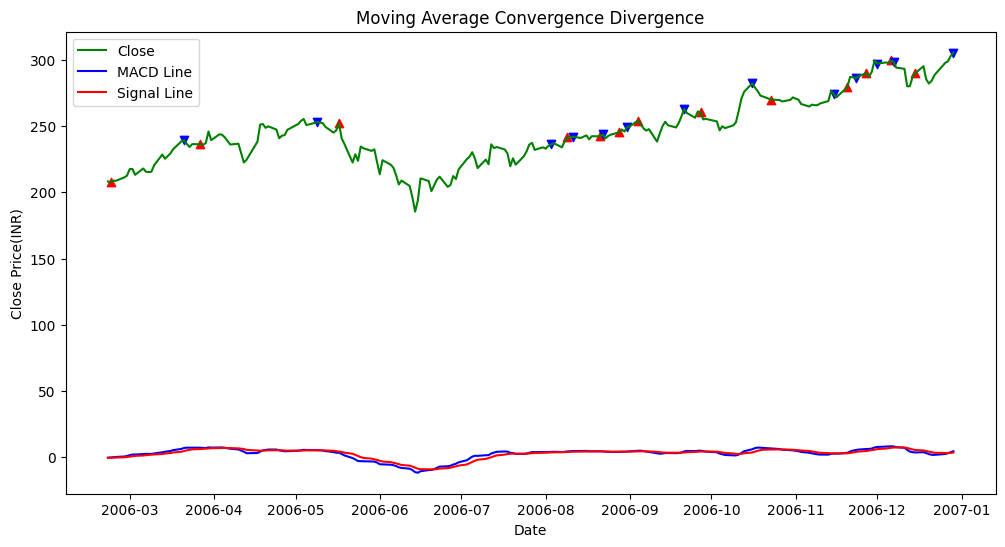

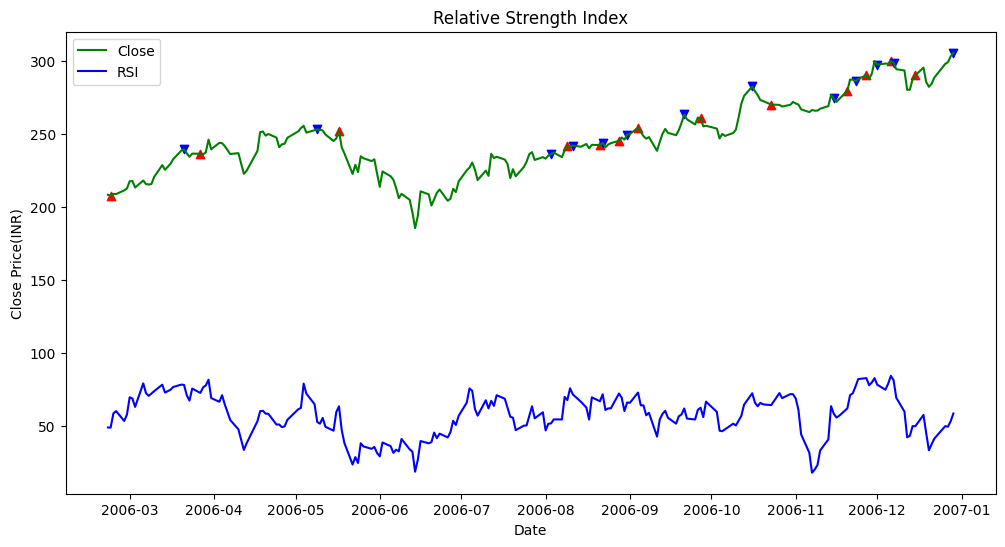

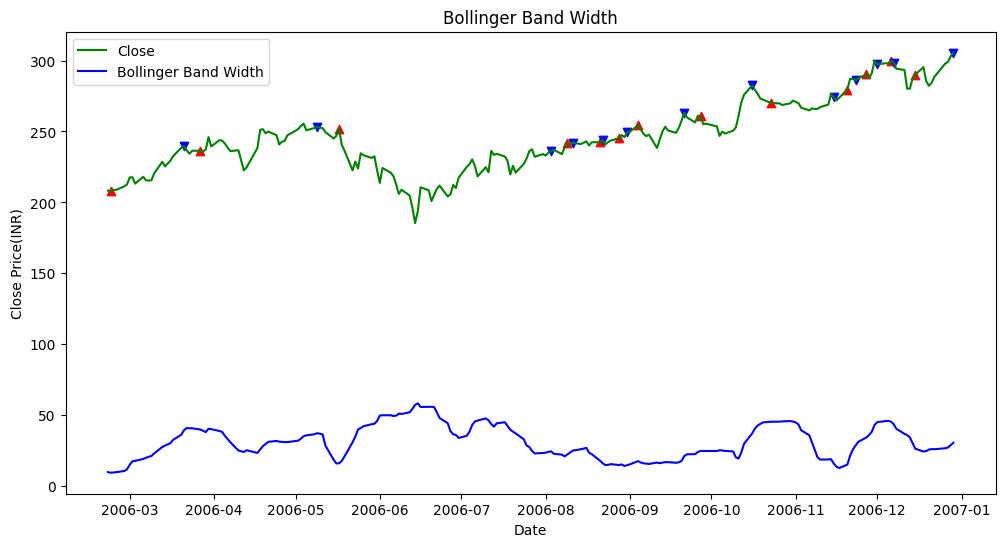

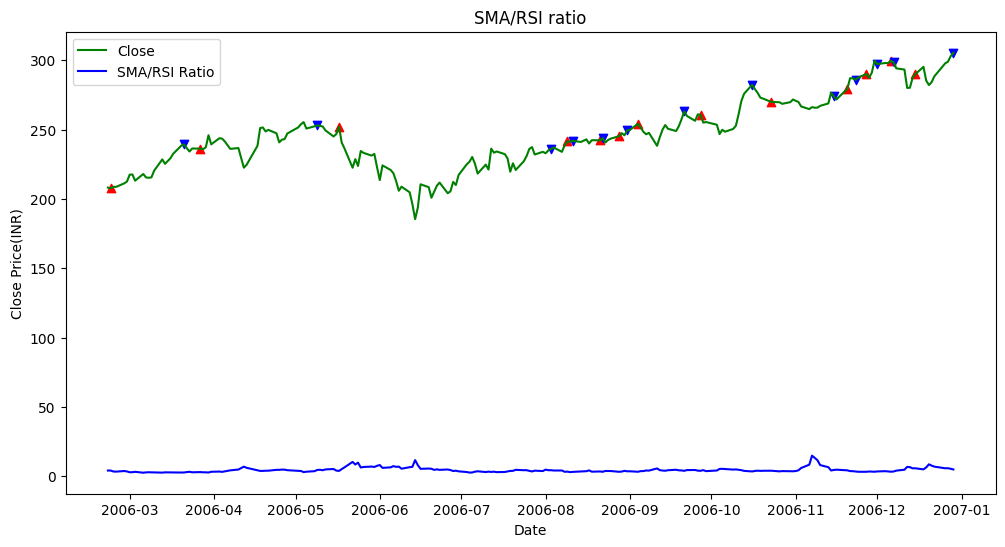

In [ ]:
#plotting graphs
plotting(price_data)

# Back Testing 2:(2020 to 2022)

Importing data and feature engineering

In [ ]:
#Importing data and feature engineering
price_data = yf.download("TCS.NS", start="2020-01-01", end="2022-01-01")
price_data=feature_engineering(price_data)

[*********************100%%**********************]  1 of 1 completed


Labeling Data

In [ ]:
#Labeling Data
price_data['Price_Direction'] = (price_data['Close'].shift(-1) > price_data['Close']).astype(int)
labels = price_data['Price_Direction']

position = []
target=[]
money=12000
shares=0

for i in range(len(labels)):
  close_price = price_data.iloc[i]['Close']

  if labels[i]== 0 and shares > 0:  # Sell condition
        money += shares * close_price  # Add money from selling shares
        shares = 0  # Reset shares to 0 after selling
        position.append('Sell')
        target.append(0)
  elif labels[i-1] == 1 and shares == 0:  # Buy condition
        shares = money // close_price  # Buy as many shares as possible
        money -= shares * close_price  # Reduce money by the purchase cost
        position.append('Buy')
        target.append(2)
  else:
        position.append('Hold')
        target.append(1)

price_data['Ideal_positions'] = position
price_data['target'] = target
print(price_data)

                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2020-01-01  2168.000000  2183.899902  2154.000000  2167.600098  1999.319214   
2020-01-02  2179.949951  2179.949951  2149.199951  2157.649902  1990.141113   
2020-01-03  2164.000000  2223.000000  2164.000000  2200.649902  2029.802856   
2020-01-06  2205.000000  2225.949951  2187.899902  2200.449951  2029.617798   
2020-01-07  2200.500000  2214.649902  2183.800049  2205.850098  2034.599487   
...                 ...          ...          ...          ...          ...   
2021-12-27  3671.000000  3700.000000  3653.100098  3696.100098  3512.472900   
2021-12-28  3710.000000  3725.000000  3693.850098  3706.550049  3522.403320   
2021-12-29  3692.250000  3719.949951  3685.000000  3694.699951  3511.142090   
2021-12-30  3681.350098  3740.000000  3680.000000  3733.750000  3548.251953   
2021-12-31  3742.800049  3760.000000  3731.300049  3

Defining features and target variable.

In [ ]:
#Defining features and target
features = [ 'sma','obv','ema','macd_line','signal_line','upper_band','lower_band','adx','stoch_k',
            'stoch_d','atr','RSI', 'sma_rsi_ratio', 'Bollinger_Band_Width'
            ]
price_data=price_data.dropna()
X = price_data[features]
y = price_data['target']
X_scaled = scaling(X)
print(X.shape,y.shape)


(466, 14) (466,)


Calculating changes in the intial capital

In [ ]:
# Calculating changes in the intial capital
predicted_labels = model.predict(X_scaled)

# Initialising an empty list to store positions
positions = []
money=12000
shares=0

for i in range(len(predicted_labels)):
  close_price = price_data.iloc[i]['Close']

  if predicted_labels[i]== 0 and shares > 0:  # Sell condition
        money += shares * close_price  # Add money from selling shares
        shares = 0  # Reset shares to 0 after selling
        positions.append('Sell')
  elif predicted_labels[i-1] == 2 and shares == 0:  # Buy condition
        shares = money // close_price  # Buy as many shares as possible
        money -= shares * close_price  # Reduce money by the purchase cost
        positions.append('Buy')
  else:
        positions.append('Hold')

# Adding positions to the price_data DataFrame
price_data['Position'] = positions

# If there are remaining shares, sell them at the last closing price
if shares > 0:
    money += shares * close_price

<ipython-input-256-f0175583a025>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_data['Position'] = positions


Model Evaluation

In [ ]:
#Model Evaluation
print('Model Evaluation:')
print('Initial Sum of money=12000')
print(f'Final sum of money={money}')
print(f'Percent profit/loss={((money-12000)/12000)*100}')
accuracy = calculate_accuracy(y, predicted_labels)
print("Accuracy:", accuracy)

f1 = calculate_f1_score(y, predicted_labels)
print("F1 Score:", f1)
print('Final Dataset:')

roc_auc=calculate_roc_score(y, predicted_labels)
print("AUC-ROC score", roc_auc)

print(price_data.head(20))


Model Evaluation:
Initial Sum of money=12000
Final sum of money=20677.249755859375
Percent profit/loss=72.31041463216145
Accuracy: 0.5364806866952789
F1 Score: 0.5503900015461096
Final Dataset:
AUC-ROC score 0.6191498025310618
                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2020-02-17  2196.949951  2217.000000  2190.199951  2203.250000  2036.815796   
2020-02-18  2199.949951  2221.000000  2186.050049  2215.750000  2048.371582   
2020-02-19  2215.750000  2230.000000  2190.500000  2196.350098  2030.437500   
2020-02-20  2204.500000  2214.399902  2151.250000  2156.800049  1993.874512   
2020-02-24  2156.000000  2178.949951  2106.699951  2115.350098  1955.555908   
2020-02-25  2115.500000  2176.649902  2111.000000  2156.149902  1993.273560   
2020-02-26  2154.000000  2163.899902  2112.949951  2123.600098  1963.182495   
2020-02-27  2119.949951  2119.949951  2086.199951  2105.500000

Plotting Graphs with technical indicators

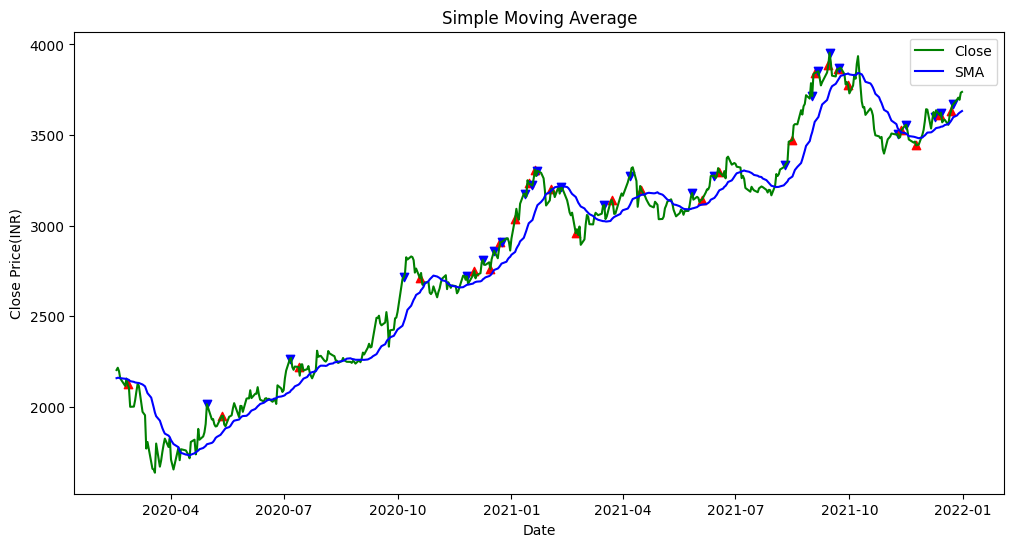

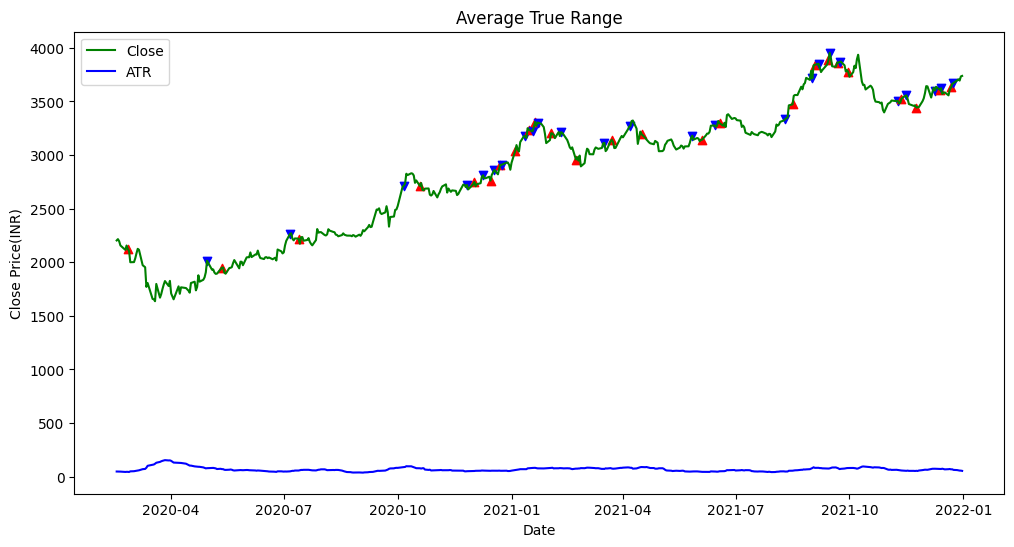

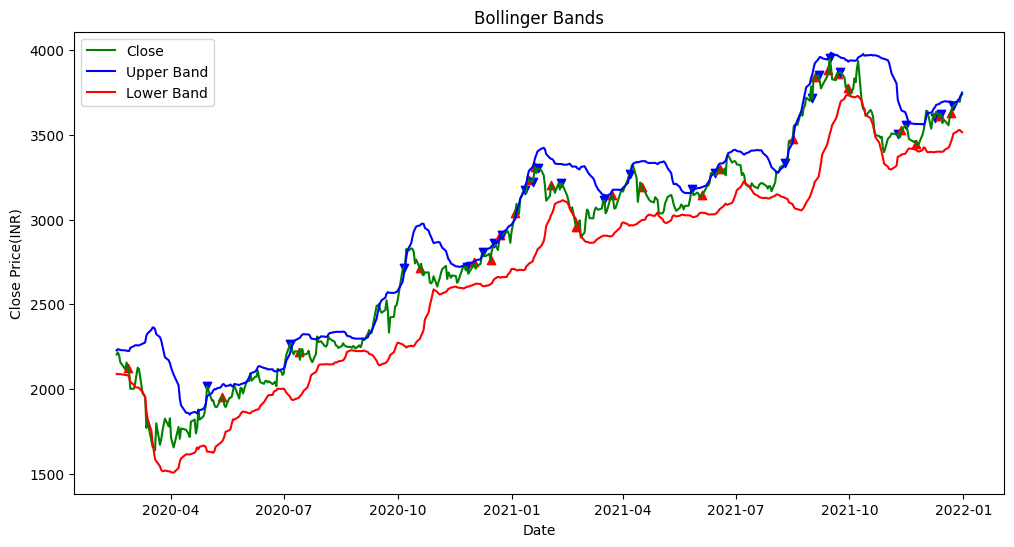

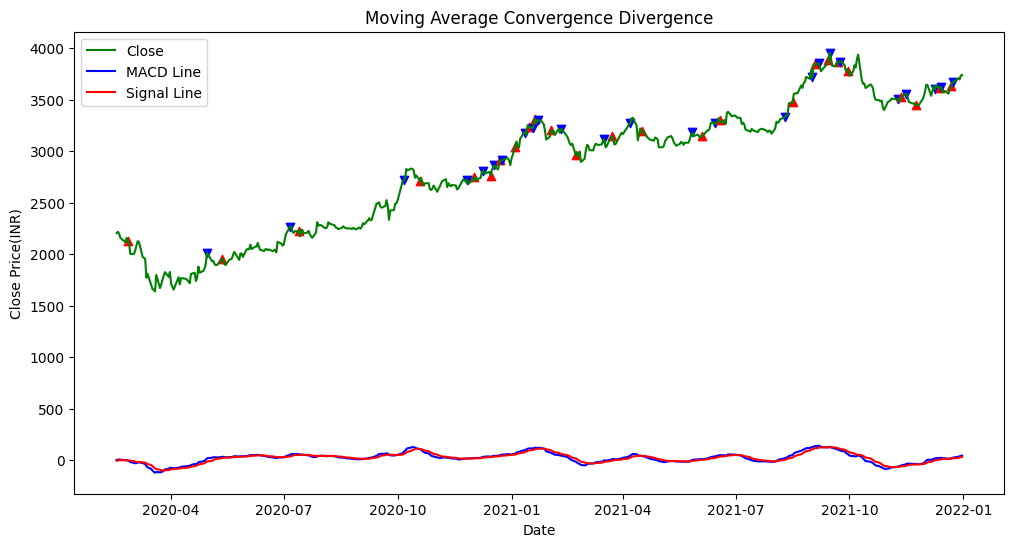

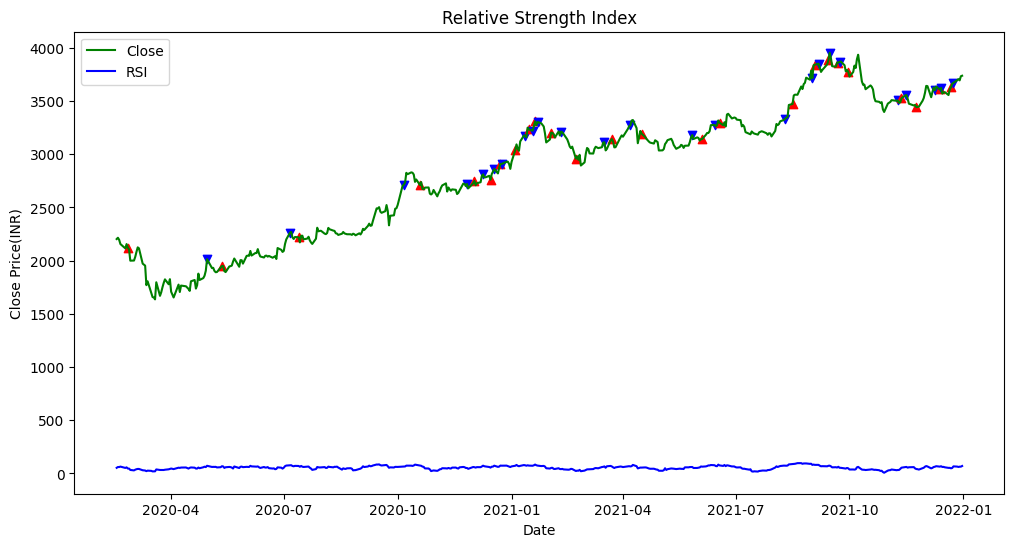

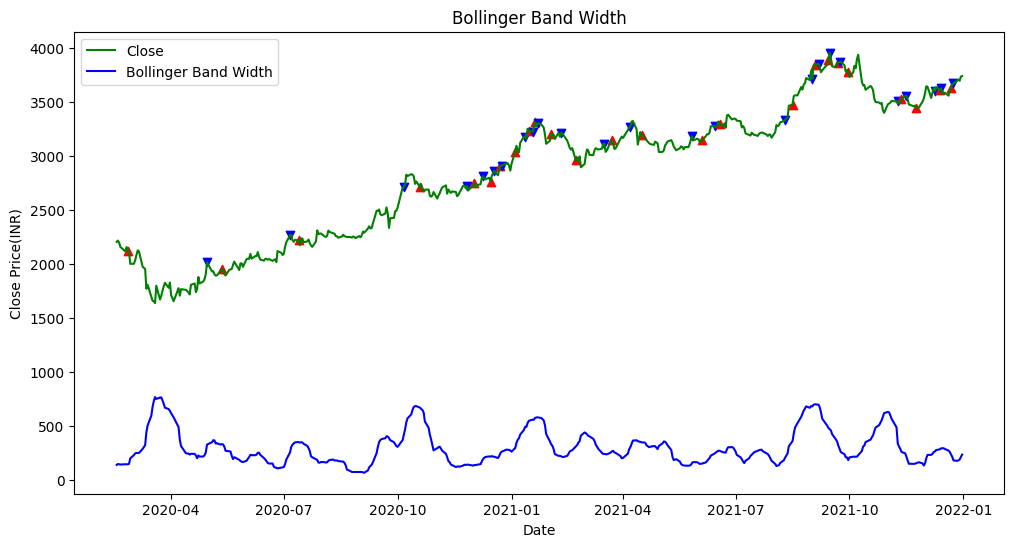

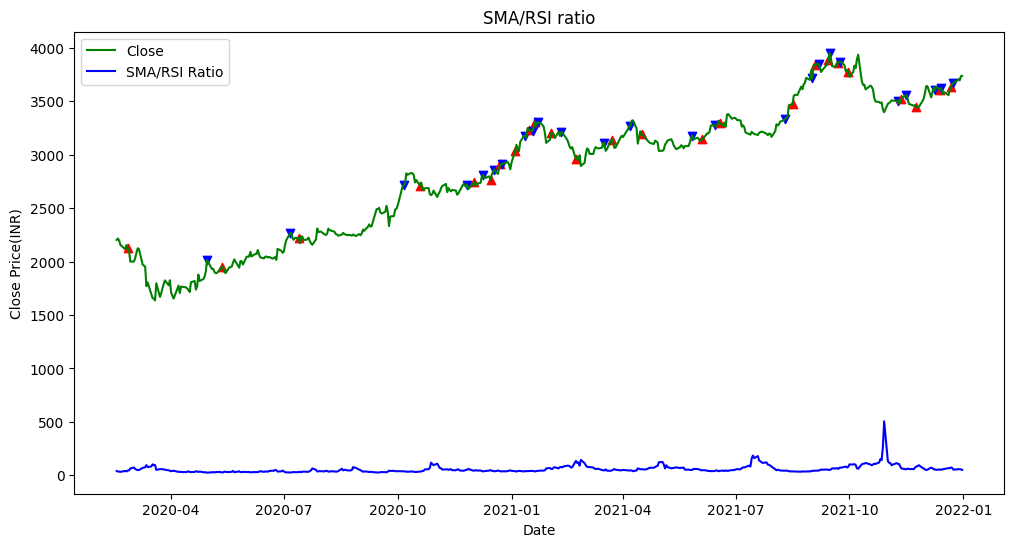

In [ ]:
#plotting graphs
plotting(price_data)

# Back Testing 3:(2018 to 2024)

Importing data and feature engineering

In [ ]:
#Importing data and feature engineering
price_data = yf.download("TCS.NS", start="2018-01-01", end="2024-01-01")
price_data=feature_engineering(price_data)

[*********************100%%**********************]  1 of 1 completed


Labeling Data

In [ ]:
#Labeling Data
price_data['Price_Direction'] = (price_data['Close'].shift(-1) > price_data['Close']).astype(int)
labels = price_data['Price_Direction']

position = []
target=[]
money=12000
shares=0

for i in range(len(labels)):
  close_price = price_data.iloc[i]['Close']

  if labels[i]== 0 and shares > 0:  # Sell condition
        money += shares * close_price  # Add money from selling shares
        shares = 0  # Reset shares to 0 after selling
        position.append('Sell')
        target.append(0)
  elif labels[i-1] == 1 and shares == 0:  # Buy condition
        shares = money // close_price  # Buy as many shares as possible
        money -= shares * close_price  # Reduce money by the purchase cost
        position.append('Buy')
        target.append(2)
  else:
        position.append('Hold')
        target.append(1)

price_data['Ideal_positions'] = position
price_data['target'] = target
print(price_data)

                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2018-01-01  1341.150024  1347.400024  1317.500000  1322.800049  1164.033081   
2018-01-02  1330.000000  1334.800049  1310.099976  1315.599976  1157.697266   
2018-01-03  1316.000000  1334.500000  1315.599976  1319.324951  1160.974976   
2018-01-04  1325.000000  1331.000000  1320.000000  1328.550049  1169.092773   
2018-01-05  1325.000000  1349.750000  1325.000000  1344.599976  1183.216919   
...                 ...          ...          ...          ...          ...   
2023-12-22  3800.000000  3845.949951  3762.000000  3824.000000  3806.362549   
2023-12-26  3819.850098  3834.000000  3790.149902  3795.550049  3778.043701   
2023-12-27  3799.000000  3818.199951  3768.000000  3811.199951  3793.621338   
2023-12-28  3824.000000  3838.000000  3792.100098  3799.899902  3782.373535   
2023-12-29  3792.000000  3822.600098  3765.399902  3

Defining features and target

In [ ]:
#Defining features and target
features = [ 'sma','obv','ema','macd_line','signal_line','upper_band','lower_band','adx','stoch_k',
            'stoch_d','atr','RSI', 'sma_rsi_ratio', 'Bollinger_Band_Width'
            ]
price_data=price_data.dropna()
X = price_data[features]
y = price_data['target']
X_scaled = scaling(X)
print(X.shape,y.shape)


(1448, 14) (1448,)


Calculating changes in the intial capital

In [ ]:
# Calculating changes in the intial capital
predicted_labels = model.predict(X_scaled)

# Initialising an empty list to store positions
positions = []
money=12000
shares=0

for i in range(len(predicted_labels)):
  close_price = price_data.iloc[i]['Close']

  if predicted_labels[i]== 0 and shares > 0:  # Sell condition
        money += shares * close_price  # Add money from selling shares
        shares = 0  # Reset shares to 0 after selling
        positions.append('Sell')
  elif predicted_labels[i-1] == 2 and shares == 0:  # Buy condition
        shares = money // close_price  # Buy as many shares as possible
        money -= shares * close_price  # Reduce money by the purchase cost
        positions.append('Buy')
  else:
        positions.append('Hold')

# Adding positions to the price_data DataFrame
price_data['Position'] = positions

# If there are remaining shares, sell them at the last closing price
if shares > 0:
    money += shares * close_price


<ipython-input-262-f0175583a025>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_data['Position'] = positions


Model Evaluation

In [ ]:
#Model Evaluation
print('Model Evaluation:')
print('Initial Sum of money=12000')
print(f'Final sum of money={money}')
print(f'Percent profit/loss={((money-12000)/12000)*100}')
accuracy = calculate_accuracy(y, predicted_labels)
print("Accuracy:", accuracy)

f1 = calculate_f1_score(y, predicted_labels)
print("F1 Score:", f1)
print('Final Dataset:')

roc_auc=calculate_roc_score(y, predicted_labels)
print("AUC-ROC score", roc_auc)

print(price_data.head(20))


Model Evaluation:
Initial Sum of money=12000
Final sum of money=31786.461303710938
Percent profit/loss=164.88717753092448
Accuracy: 0.537292817679558
F1 Score: 0.5477092633726443
Final Dataset:
AUC-ROC score 0.6153201965212602
                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2018-02-19  1472.500000  1476.650024  1447.599976  1461.800049  1289.399658   
2018-02-20  1464.000000  1492.525024  1463.949951  1472.375000  1298.727295   
2018-02-21  1487.000000  1531.300049  1480.025024  1521.150024  1341.749878   
2018-02-22  1526.000000  1539.500000  1511.250000  1525.099976  1345.234131   
2018-02-23  1525.000000  1544.500000  1496.050049  1537.900024  1356.524414   
2018-02-26  1537.500000  1544.974976  1510.599976  1515.849976  1337.075317   
2018-02-27  1520.500000  1539.275024  1516.000000  1521.175049  1341.772095   
2018-02-28  1517.500000  1531.974976  1510.724976  1517.525024

Plotting Graphs with technical indicators

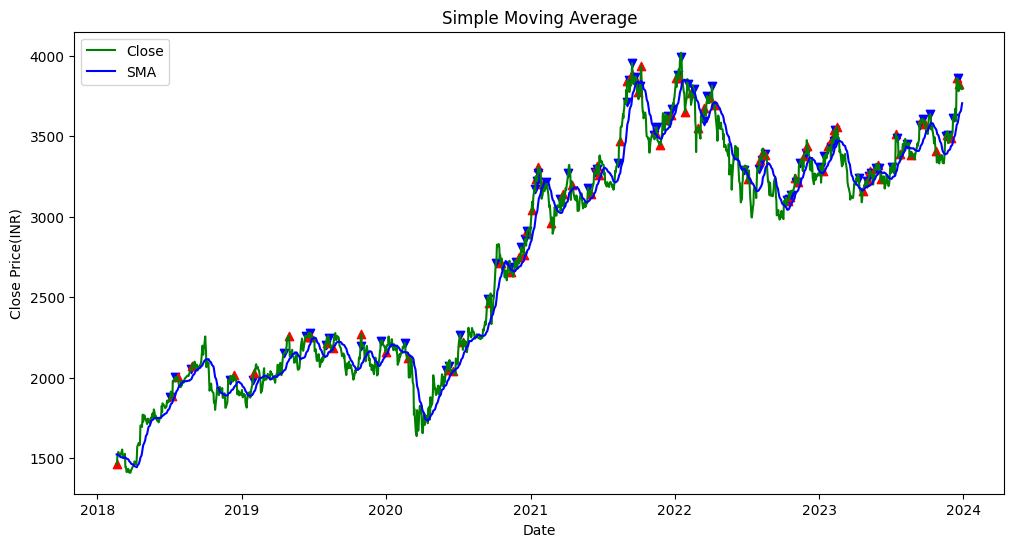

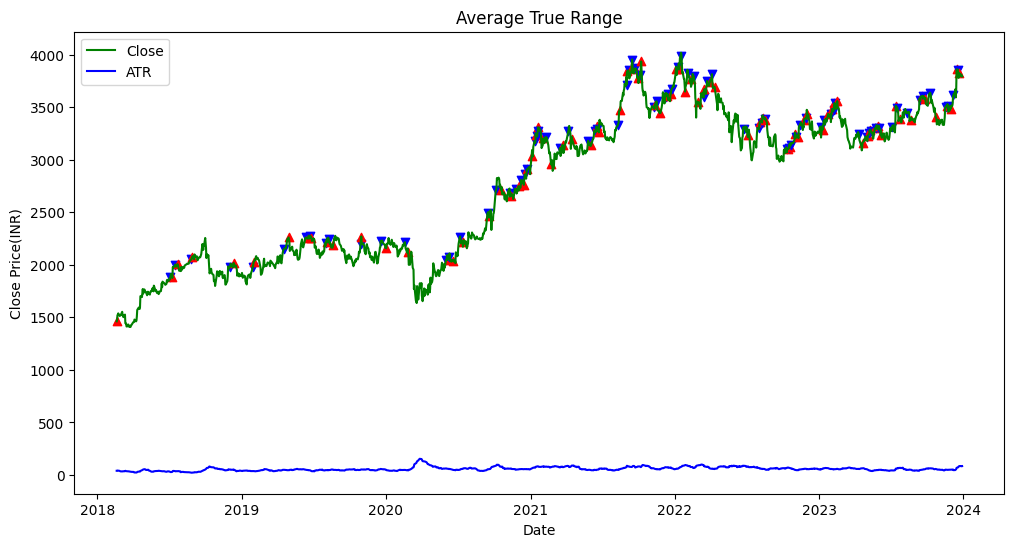

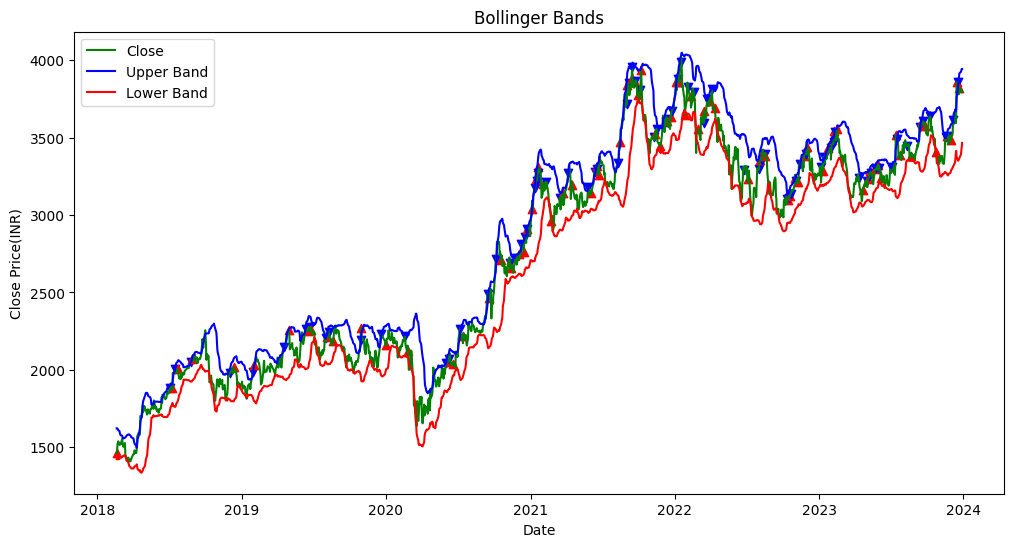

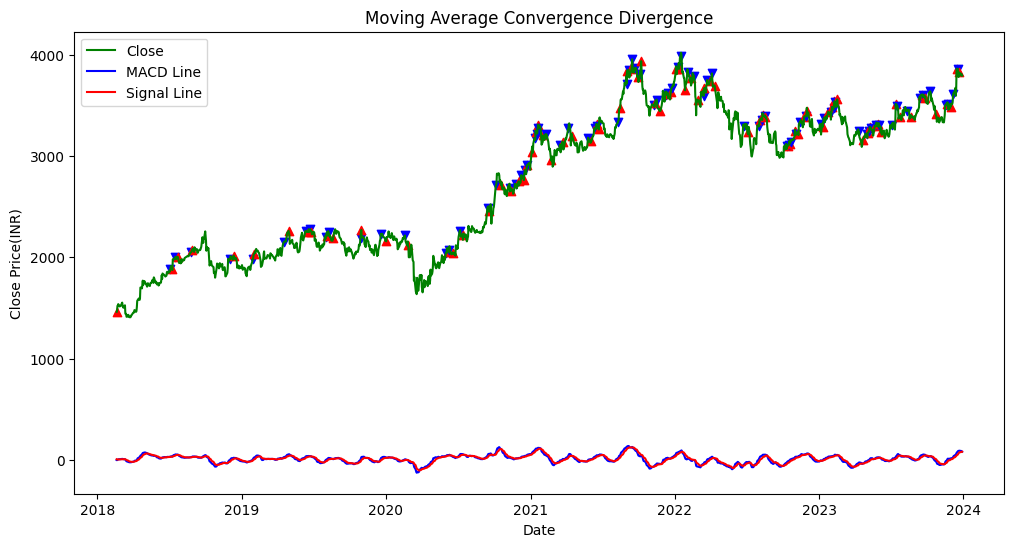

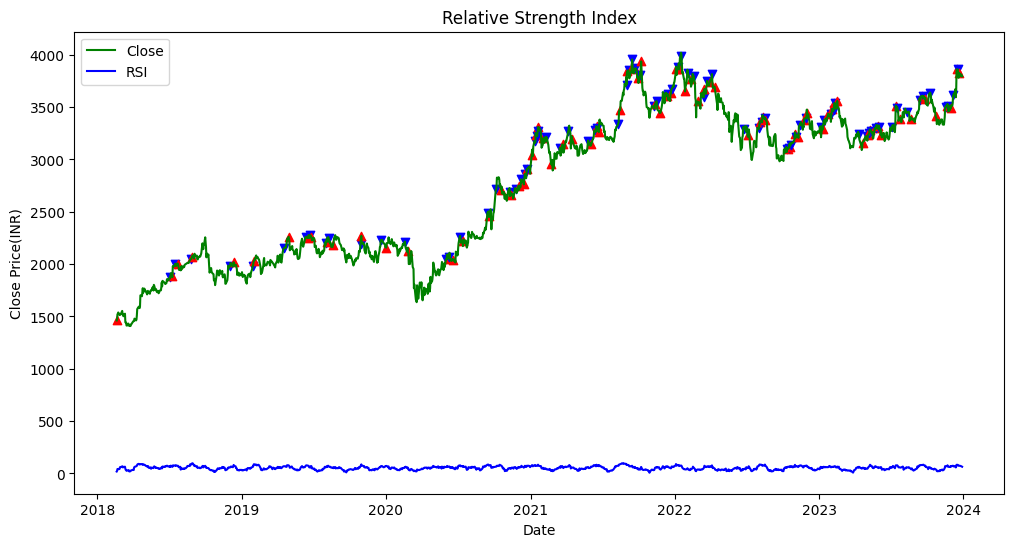

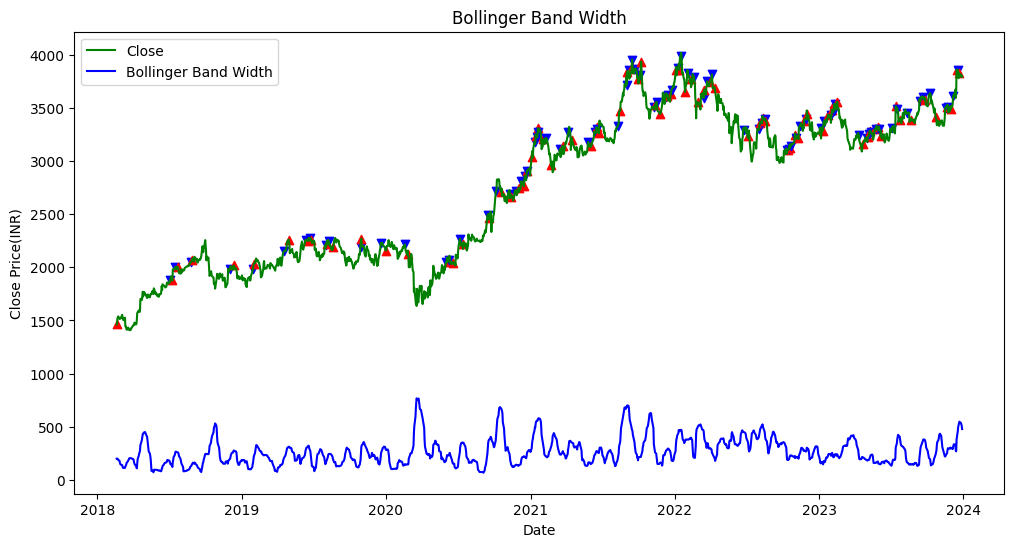

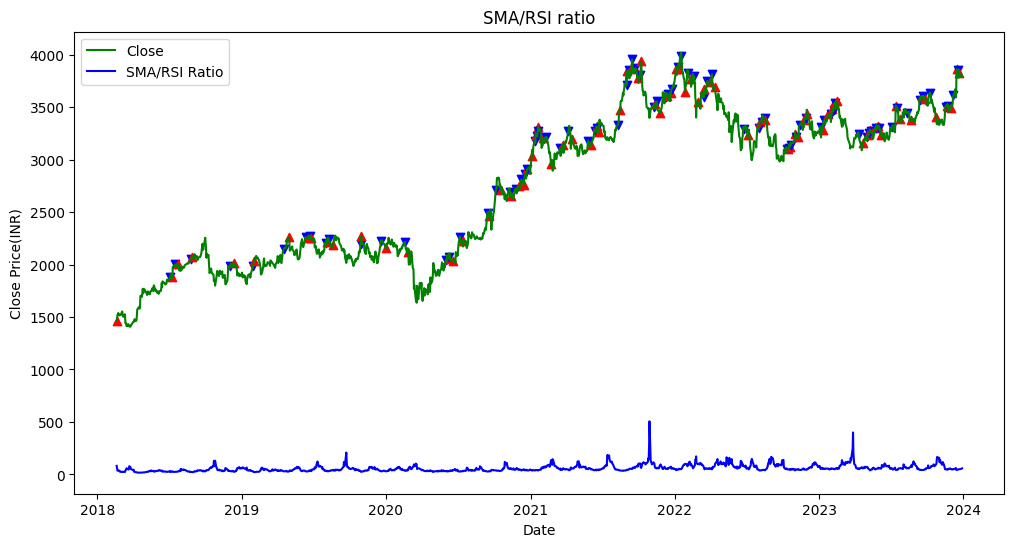

In [ ]:
#plotting graphs
plotting(price_data)

# Back Testing 4:(Past three months)

Importing data and feature engineering

In [ ]:
#Importing data and feature engineering
price_data = yf.download("TCS.NS", start="2023-11-10", end="2024-03-17")
price_data=feature_engineering(price_data)

[*********************100%%**********************]  1 of 1 completed


Labeling Data

In [ ]:
#Labeling Data
price_data['Price_Direction'] = (price_data['Close'].shift(-1) > price_data['Close']).astype(int)
labels = price_data['Price_Direction']

position = []
target=[]
money=12000
shares=0

for i in range(len(labels)):
  close_price = price_data.iloc[i]['Close']

  if labels[i]== 0 and shares > 0:  # Sell condition
        money += shares * close_price  # Add money from selling shares
        shares = 0  # Reset shares to 0 after selling
        position.append('Sell')
        target.append(0)
  elif labels[i-1] == 1 and shares == 0:  # Buy condition
        shares = money // close_price  # Buy as many shares as possible
        money -= shares * close_price  # Reduce money by the purchase cost
        position.append('Buy')
        target.append(2)
  else:
        position.append('Hold')
        target.append(1)

price_data['Ideal_positions'] = position
price_data['target'] = target
print(price_data)

                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2023-11-10  3338.000000  3347.449951  3322.350098  3333.449951  3318.074951   
2023-11-13  3356.000000  3356.000000  3327.000000  3331.550049  3316.183838   
2023-11-15  3383.100098  3413.000000  3356.050049  3404.300049  3388.598389   
2023-11-16  3430.050049  3529.350098  3414.199951  3497.850098  3481.716797   
2023-11-17  3497.850098  3524.500000  3492.550049  3502.449951  3486.295410   
...                 ...          ...          ...          ...          ...   
2024-03-11  4089.000000  4153.000000  4089.000000  4122.350098  4122.350098   
2024-03-12  4122.350098  4229.950195  4121.049805  4192.250000  4192.250000   
2024-03-13  4205.000000  4241.000000  4131.899902  4149.000000  4149.000000   
2024-03-14  4153.450195  4225.000000  4086.000000  4207.600098  4207.600098   
2024-03-15  4192.600098  4239.000000  4177.000000  4

Defining features and target

In [ ]:
#Defining features and target
features = [ 'sma','obv','ema','macd_line','signal_line','upper_band','lower_band','adx','stoch_k',
            'stoch_d','atr','RSI', 'sma_rsi_ratio', 'Bollinger_Band_Width'
            ]
price_data=price_data.dropna()
X = price_data[features]
y = price_data['target']
X_scaled = scaling(X)
print(X.shape,y.shape)


(52, 14) (52,)


Calculating changes in the intial capital

In [ ]:
# Calculating changes in the intial capital
predicted_labels = model.predict(X_scaled)

# Initialising an empty list to store positions
positions = []
money=12000
shares=0

for i in range(len(predicted_labels)):
  close_price = price_data.iloc[i]['Close']

  if predicted_labels[i]== 0 and shares > 0:  # Sell condition
        money += shares * close_price  # Add money from selling shares
        shares = 0  # Reset shares to 0 after selling
        positions.append('Sell')
  elif predicted_labels[i-1] == 2 and shares == 0:  # Buy condition
        shares = money // close_price  # Buy as many shares as possible
        money -= shares * close_price  # Reduce money by the purchase cost
        positions.append('Buy')
  else:
        positions.append('Hold')

# Adding positions to the price_data DataFrame
price_data['Position'] = positions

# If there are remaining shares, sell them at the last closing price
if shares > 0:
    money += shares * close_price


<ipython-input-268-f0175583a025>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_data['Position'] = positions


Model Evaluation

In [ ]:
#Model Evaluation
print('Model Evaluation:')
print('Initial Sum of money=12000')
print(f'Final sum of money={money}')
print(f'Percent profit/loss={((money-12000)/12000)*100}')
accuracy = calculate_accuracy(y, predicted_labels)
print("Accuracy:", accuracy)

f1 = calculate_f1_score(y, predicted_labels)
print("F1 Score:", f1)
print('Final Dataset:')

roc_auc=calculate_roc_score(y, predicted_labels)
print("AUC-ROC score", roc_auc)

print(price_data.head(20))


Model Evaluation:
Initial Sum of money=12000
Final sum of money=13175.1005859375
Percent profit/loss=9.7925048828125
Accuracy: 0.5769230769230769
F1 Score: 0.5995603661044838
Final Dataset:
AUC-ROC score 0.6704365079365079
                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2024-01-01  3790.000000  3832.000000  3773.000000  3811.100098  3793.521973   
2024-01-02  3811.100098  3811.100098  3767.250000  3783.199951  3765.750488   
2024-01-03  3767.000000  3771.850098  3687.050049  3691.750000  3674.722412   
2024-01-04  3701.750000  3719.000000  3651.000000  3666.800049  3649.887451   
2024-01-05  3675.000000  3747.750000  3674.850098  3737.899902  3720.659424   
2024-01-08  3737.899902  3739.750000  3672.399902  3678.300049  3661.334473   
2024-01-09  3709.949951  3752.350098  3682.750000  3689.899902  3672.880859   
2024-01-10  3690.000000  3729.250000  3688.000000  3713.050049  36

Plotting Graphs with technical indicators

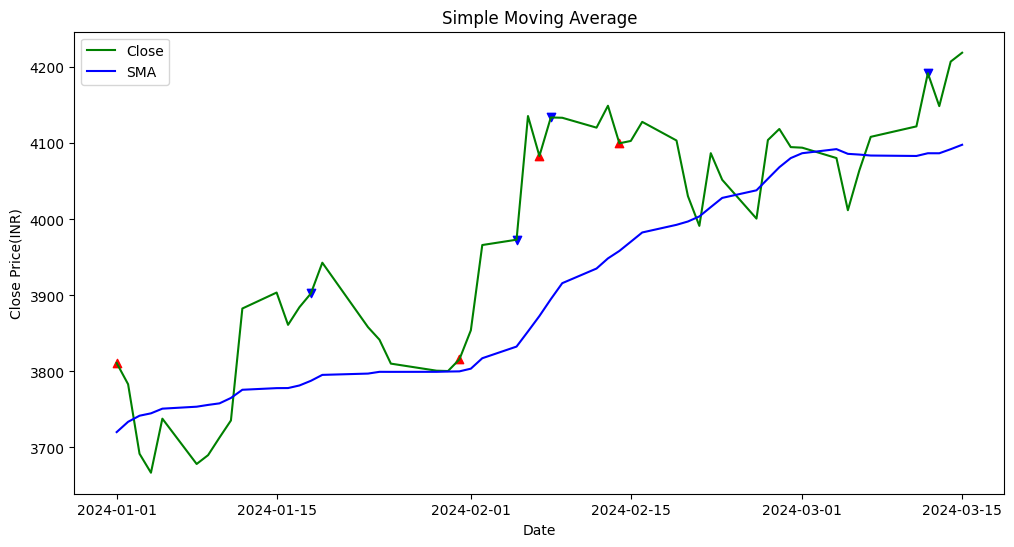

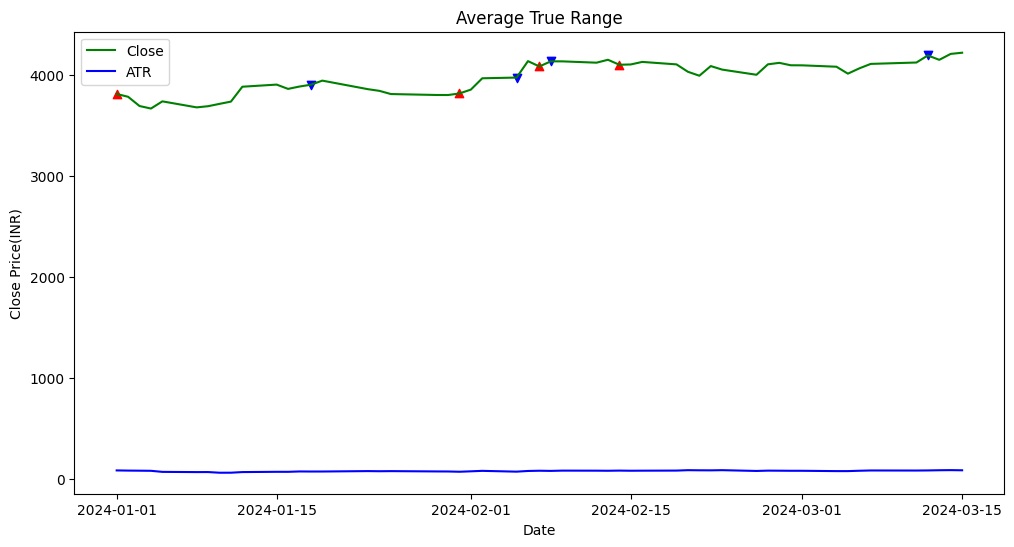

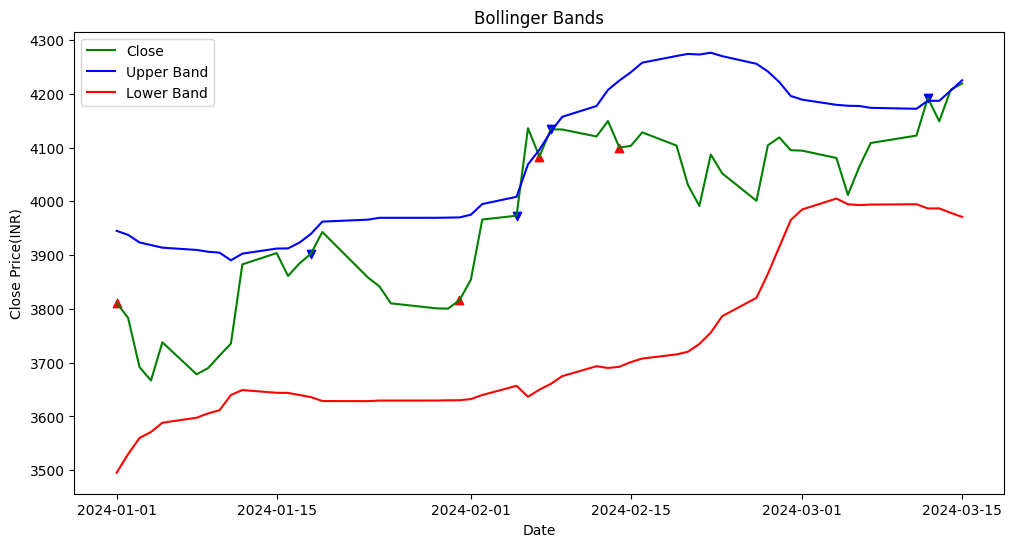

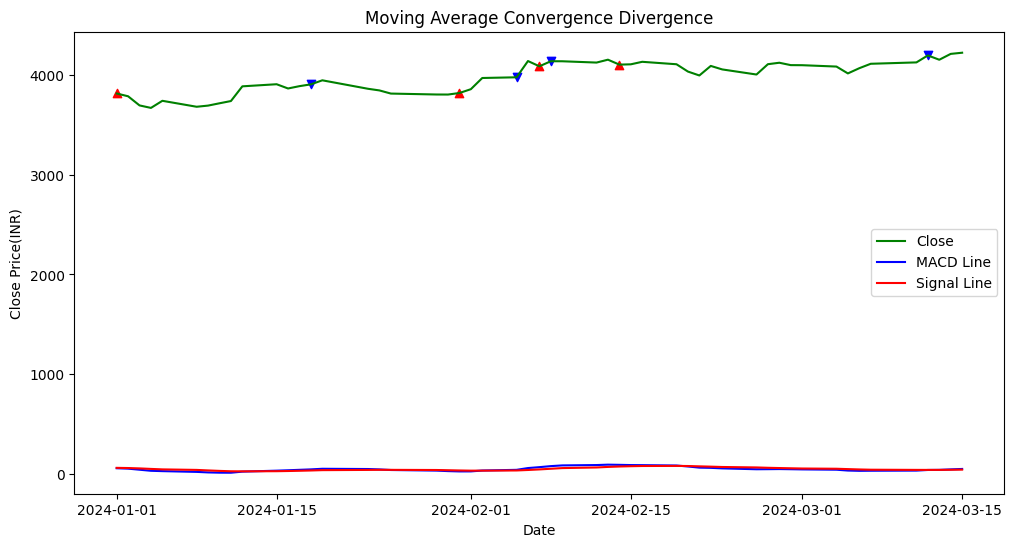

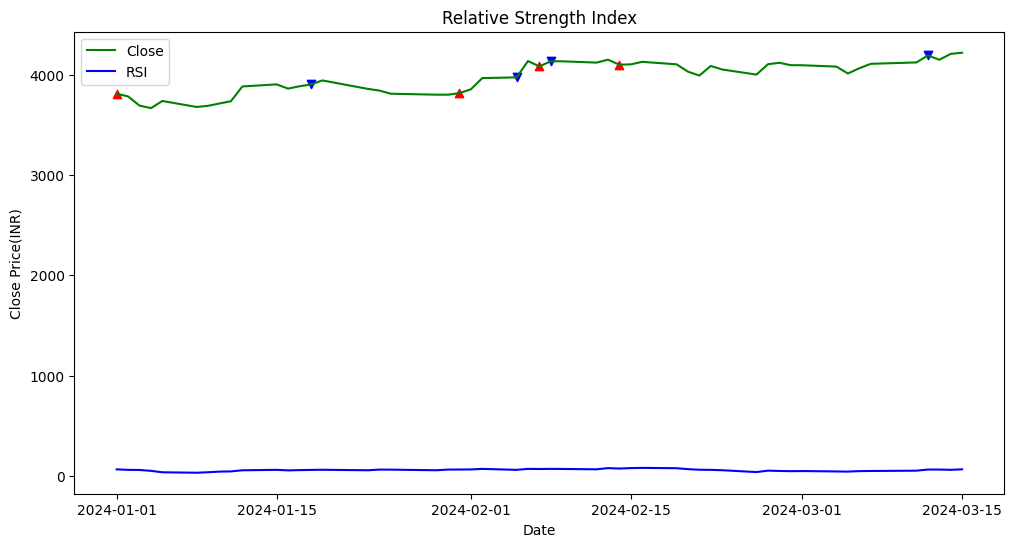

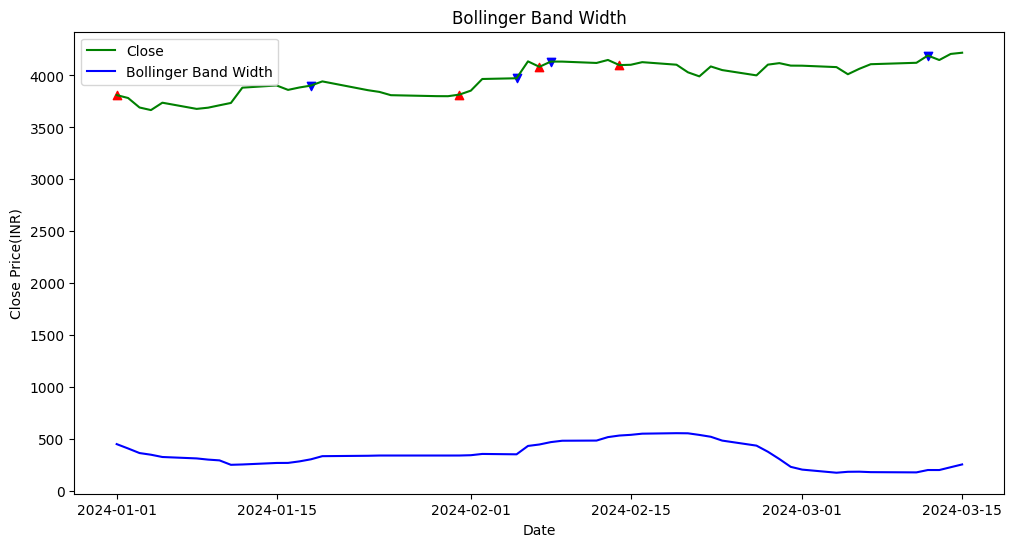

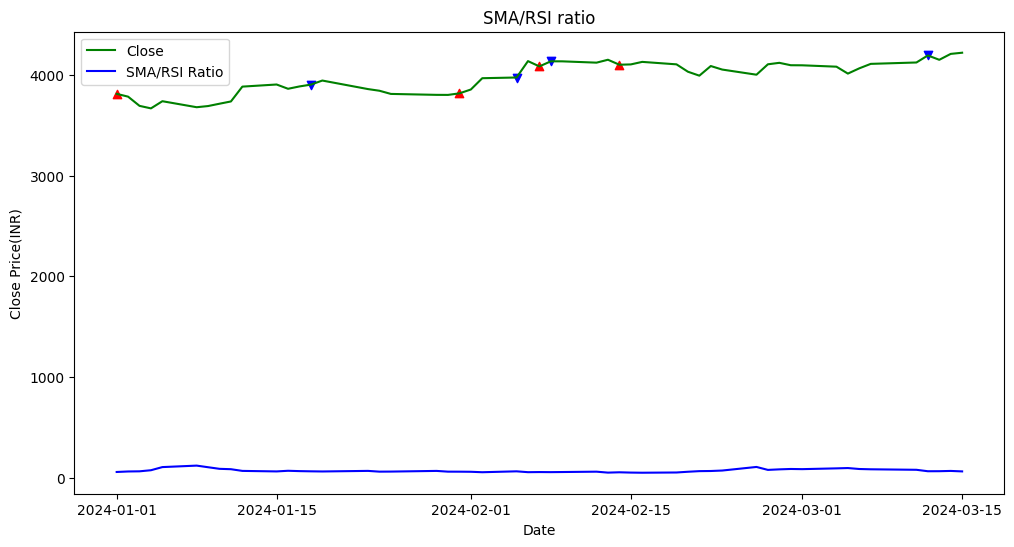

In [ ]:
#plotting graphs
plotting(price_data)